In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# need this cell to import the help functions:

import os
path_sections = os.getcwd().split('\\')
if path_sections[-1] != 'CGM':
    os.chdir('./..')

In [7]:
# import help functions:

from data_processing.cgm_data import CGMData
from data_processing.cgm_data_helper import plot_series_with_food
from data_processing.derived_datasets import max_glucose_dataset,max_glucose_between_meals_dataset

from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix

In [8]:
data = CGMData()

In [9]:
# participant_numbers = data.shape()
participant_numbers = 13

In [10]:
# Finding 5/95th percentile idea from Dan Visscher
high_glu = []
low_glu = []

# Find 5th/95th percentile for glucose range for each patient
for i in range(1,participant_numbers+1):
    low_glu.append(np.percentile(data[i].glu, 5))
    high_glu.append(np.percentile(data[i].glu, 95))


In [11]:
print(high_glu)
print(low_glu)

[137.0]
[85.0]


In [12]:
df = pd.DataFrame()

for pn in range(1,participant_numbers+1):
    # Select participant number
    participant_number = pn
    high_glu_par = high_glu[participant_number-1]

    # Max glucose between meals:
    df_sub = max_glucose_dataset(cgm_data=data,participant_num=participant_number,glu_thresh=high_glu_par)
    df = pd.concat([df, pd.DataFrame(df_sub)])

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   calorie        20 non-null     float64
 1   total_carb     20 non-null     float64
 2   dietary_fiber  20 non-null     float64
 3   sugar          20 non-null     float64
 4   protein        20 non-null     float64
 5   total_fat      20 non-null     float64
 6   gi             20 non-null     float64
 7   gl             20 non-null     float64
 8   recent_meals   20 non-null     float64
 9   participant    20 non-null     int64  
 10  max_glucose    20 non-null     float64
 11  start_glucose  20 non-null     float64
 12  diff_glucose   20 non-null     float64
 13  mean_temp      19 non-null     float64
 14  mean_hr        20 non-null     float64
 15  mean_acc       19 non-null     float64
 16  mean_eda       19 non-null     float64
 17  high_glucose   20 non-null     bool   
dtypes: bool(1), 

In [13]:
# Number of food intake entries for which there is no corresponding glucose data
df['max_glucose'].isna().sum()

0

In [14]:
# Drop these data points
df = df.dropna(subset=['max_glucose'])

In [15]:
# Check
df['max_glucose'].isna().sum()

0

In [16]:
df

,calorie,total_carb,dietary_fiber,sugar,protein,total_fat,gi,gl,recent_meals,participant,max_glucose,start_glucose,diff_glucose,mean_temp,mean_hr,mean_acc,mean_eda,high_glucose
0,456.0,85.0,1.7,83.0,16.0,3.3,33.00,28.050,1.0,1,143.0,59.0,84.0,33.605343,76.982429,0.924898,0.478566,True
1,488.0,2.5,1.2,0.8,63.4,23.1,28.00,0.700,1.0,1,106.0,104.0,2.0,34.328719,68.960515,0.661794,2.321904,False
2,230.0,35.0,0.0,18.0,13.0,0.0,56.50,24.620,1.0,1,122.0,92.0,30.0,33.882256,77.987660,0.791241,0.568190,False
3,280.0,30.0,0.0,22.0,4.0,0.0,62.00,18.600,1.0,1,110.0,89.0,21.0,31.511428,87.463506,0.964078,0.483317,False
4,358.0,14.4,0.0,8.7,13.9,0.0,28.00,4.032,1.0,1,124.0,105.0,19.0,30.470737,75.821212,0.461761,0.209723,False
5,308.0,69.0,0.0,38.0,7.2,0.0,28.00,19.320,1.0,1,102.0,85.0,17.0,30.332354,75.666404,0.626606,0.152923,False
6,418.0,37.2,0.0,11.5,42.0,0.0,45.75,21.956,1.0,1,114.0,90.0,24.0,NaN,74.494000,NaN,NaN,False
7,12.0,3.4,0.0,0.0,0.2,0.0,28.00,0.952,1.0,1,142.0,140.0,2.0,34.987253,66.857595,0.362544,0.145434,True
8,158.0,33.0,0.0,13.0,4.0,0.0,85.00,28.050,1.0,1,124.0,91.0,33.0,31.658248,94.706224,1.640759,0.401689,False
9,227.0,28.2,0.0,17.0,7.5,0.0,62.00,17.484,1.0,1,119.0,93.0,26.0,30.456106,78.755962,0.828152,0.109823,False


In [17]:
# Remove outlier
df = df[df['total_carb'] <= 400]

In [18]:
# Define variables to fit for Logistic Regression

X = df[['total_carb','sugar','protein','total_fat','gi','start_glucose']]
y = df.high_glucose.values

In [19]:
X

,total_carb,sugar,protein,total_fat,gi,start_glucose
0,85.0,83.0,16.0,3.3,33.00,59.0
1,2.5,0.8,63.4,23.1,28.00,104.0
2,35.0,18.0,13.0,0.0,56.50,92.0
3,30.0,22.0,4.0,0.0,62.00,89.0
4,14.4,8.7,13.9,0.0,28.00,105.0
5,69.0,38.0,7.2,0.0,28.00,85.0
6,37.2,11.5,42.0,0.0,45.75,90.0
7,3.4,0.0,0.2,0.0,28.00,140.0
8,33.0,13.0,4.0,0.0,85.00,91.0
9,28.2,17.0,7.5,0.0,62.00,93.0


In [20]:
# Split testing and training data

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       shuffle=True,
                                                       random_state=435,
                                                       test_size=.2,
                                                       stratify=y)

In [21]:
X_train

,total_carb,sugar,protein,total_fat,gi,start_glucose
4,14.4,8.7,13.9,0.0,28.0,105.0
19,82.0,40.0,26.0,26.0,85.0,93.0
2,35.0,18.0,13.0,0.0,56.5,92.0
16,22.0,1.0,67.0,0.0,62.0,123.0
14,34.0,21.0,3.0,0.0,85.0,106.0
17,96.0,42.4,12.7,0.0,44.5,100.0
13,92.0,75.0,5.0,0.0,85.0,110.0
9,28.2,17.0,7.5,0.0,62.0,93.0
8,33.0,13.0,4.0,0.0,85.0,91.0
18,35.0,18.0,13.0,0.0,56.5,103.0


# Baseline model: categorize high glucose using total carbs

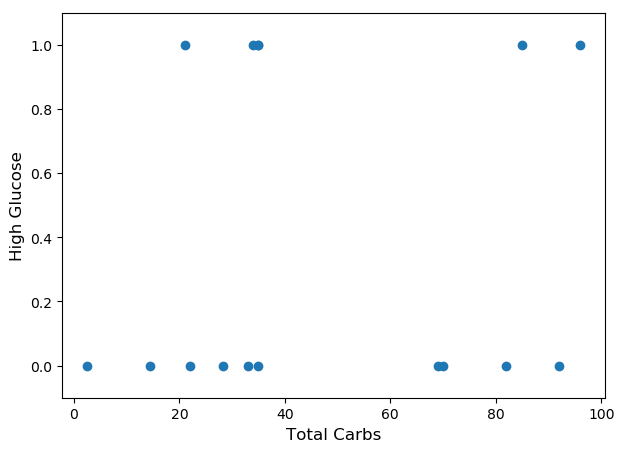

In [36]:
# Plot the training data

plt.figure(figsize = (7,5))

plt.scatter(X_train['total_carb'],y_train)
plt.ylim((-.1,1.1))
plt.xlabel("Total Carbs",fontsize = 12)
plt.ylabel("High Glucose",fontsize = 12)

plt.show()

In [37]:
# Instantiate the logistic regression
log_reg = LogisticRegression(penalty=None)

# Fit the model
log_reg.fit(X_train['total_carb'].values.reshape(-1,1),
            y_train)

LogisticRegression(penalty=None)

In [38]:
# Make predictions
log_reg.predict(X_train['total_carb'].values.reshape(-1,1))

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [39]:
# Quantify the prediction probabilities
log_reg.predict_proba(X_train['total_carb'].values.reshape(-1,1))

array([[0.67997757, 0.32002243],
       [0.56541151, 0.43458849],
       [0.64661488, 0.35338512],
       [0.66786003, 0.33213997],
       [0.64827116, 0.35172884],
       [0.54030445, 0.45969555],
       [0.5475045 , 0.4524955 ],
       [0.65780643, 0.34219357],
       [0.64992389, 0.35007611],
       [0.64661488, 0.35338512],
       [0.58843123, 0.41156877],
       [0.66946764, 0.33053236],
       [0.69846874, 0.30153126],
       [0.56005513, 0.43994487],
       [0.64661488, 0.35338512],
       [0.58667282, 0.41332718]])

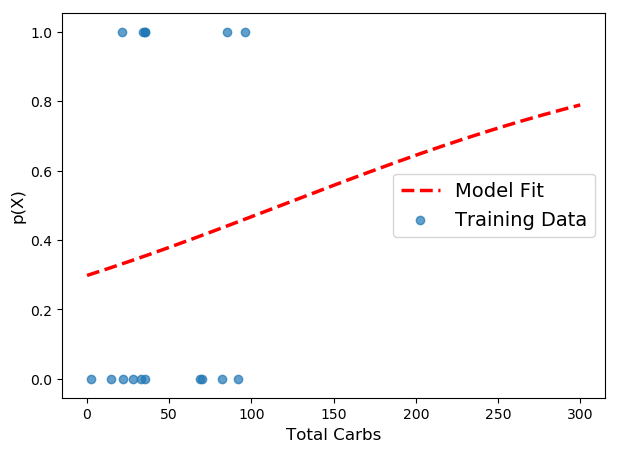

In [40]:
# Plot the training data with the logistic regression

plt.figure(figsize = (7,5))

plt.plot(np.linspace(0,300,1000),
            log_reg.predict_proba(np.linspace(0,300,1000).reshape(-1,1))[:,1],
            'r--',linewidth=2.5,label = "Model Fit")
plt.scatter(X_train['total_carb'],y_train,label = 'Training Data',alpha=.7)
plt.legend(fontsize = 14,loc = 5)
plt.xlabel("Total Carbs",fontsize = 12)
plt.ylabel("p(X)",fontsize=12) 

plt.show()

In [41]:
# Set the cutoff
cutoff = .4

# Store the predicted probabilities
y_prob = log_reg.predict_proba(X_train['total_carb'].values.reshape(-1,1))[:,1]

# Assign the value based on the cutoff
y_train_pred = 1*(y_prob >= cutoff)

# Print the accuracy
print("The training accuracy for a cutoff of",cutoff,
      "is", np.sum(y_train_pred == y_train)/len(y_train))

The training accuracy for a cutoff of 0.4 is 0.5


In [42]:
## Now plot how the accuracy changes with the cutoff
cutoffs = np.arange(0,1.01,.01)
accs = []

for cutoff in cutoffs:
    y_train_pred = 1*(y_prob >= cutoff)
    accs.append(np.sum(y_train_pred == y_train)/len(y_train))

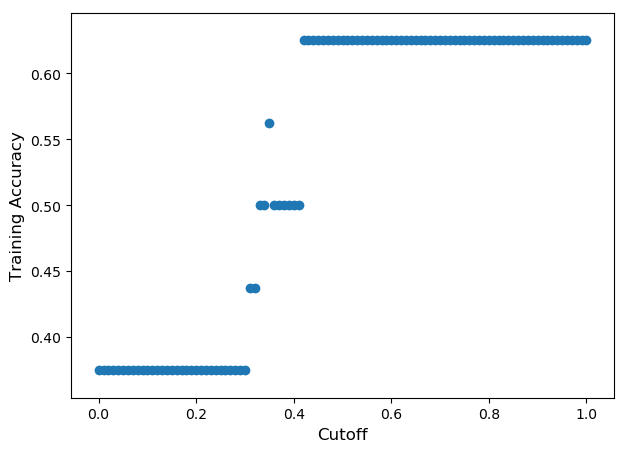

In [43]:
plt.figure(figsize=(7,5))

plt.scatter(cutoffs,accs)

plt.xlabel("Cutoff",fontsize=12)
plt.ylabel("Training Accuracy",fontsize=12)

plt.show()

In [29]:
from sklearn.metrics import roc_curve

In [44]:
fprs, tprs, cutoffs = roc_curve(y_train, log_reg.predict_proba(X_train['total_carb'].values.reshape(-1,1))[:,1])

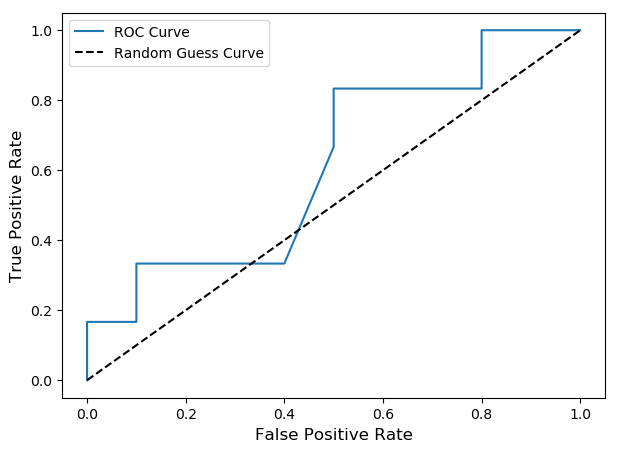

In [45]:
plt.figure(figsize=(7,5))

plt.plot(fprs, tprs, label="ROC Curve")
plt.plot([0,1], [0,1], 'k--', label="Random Guess Curve")


plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)

plt.show()

In [46]:
from sklearn.metrics import confusion_matrix

In [47]:
# Set the cutoff
cutoff = .4

# Store the predicted probabilities
y_prob = log_reg.predict_proba(X_train['total_carb'].values.reshape(-1,1))[:,1]

# Assign the value based on the cutoff
y_train_pred = 1*(y_prob >= cutoff)

# Confustion matrix
confusion_matrix(y_train, y_train_pred)

array([[6, 4],
       [4, 2]], dtype=int64)

In [48]:
TN = confusion_matrix(y_train, y_train_pred)[0,0]
FP = confusion_matrix(y_train, y_train_pred)[0,1]
FN = confusion_matrix(y_train, y_train_pred)[1,0]
TP = confusion_matrix(y_train, y_train_pred)[1,1]

## TPR
print("The training true positive rate is",
         np.round(TP/(TP+FN),4))

## FNR
print("The training false negative rate is",
         np.round(FN/(TP+FN),4))

## TNR
print("The training true negative rate is",
         np.round(TN/(TN+FP),4))

## FPR
print("The training false positive rate is",
         np.round(FP/(FP+TN),4))

The training true positive rate is 0.3333
The training false negative rate is 0.6667
The training true negative rate is 0.6
The training false positive rate is 0.4


In [49]:
## demonstrate log_reg.coef_
log_reg.coef_[0][0]

0.007256132229979189

In [50]:
print("A .1 unit increase in our feature multiplies" + 
      " the odds of being classified as 1 by " + 
      str(np.round(np.exp(.1*log_reg.coef_[0][0]),2)))

A .1 unit increase in our feature multiplies the odds of being classified as 1 by 1.0


next steps: 
1. put in data from all but the hold out participants
2. use first predictor project code to get baseline model predictions
3. predict on testing data

# Using more inputs: Model 1

In [51]:
# Instantiate the logistic regression
log_reg = LogisticRegression(penalty=None)

# Fit the model
log_reg.fit(X_train[['total_carb','gi']].values,
            y_train)

LogisticRegression(penalty=None)

In [52]:
# Set the cutoff
cutoff = .4

# Store the predicted probabilities
y_prob = log_reg.predict_proba(X_train[['total_carb','gi']].values)[:,1]

# Assign the value based on the cutoff
y_train_pred = 1*(y_prob >= cutoff)

# Print the accuracy
print("The training accuracy for a cutoff of",cutoff,
      "is", np.sum(y_train_pred == y_train)/len(y_train))

The training accuracy for a cutoff of 0.4 is 0.625


In [53]:
## Now plot how the accuracy changes with the cutoff
cutoffs = np.arange(0,1.01,.01)
accs = []

for cutoff in cutoffs:
    y_train_pred = 1*(y_prob >= cutoff)
    accs.append(np.sum(y_train_pred == y_train)/len(y_train))

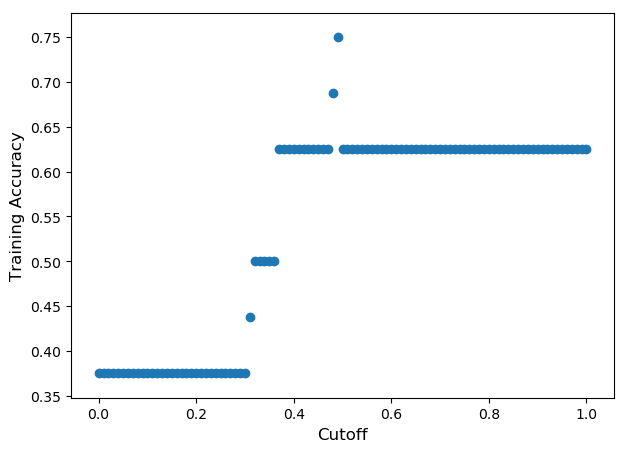

In [54]:
plt.figure(figsize=(7,5))

plt.scatter(cutoffs,accs)

plt.xlabel("Cutoff",fontsize=12)
plt.ylabel("Training Accuracy",fontsize=12)

plt.show()

In [55]:
# Set the cutoff
cutoff = .35

# Store the predicted probabilities
y_prob = log_reg.predict_proba(X_train[['total_carb','gi']].values)[:,1]

# Assign the value based on the cutoff
y_train_pred = 1*(y_prob >= cutoff)

# Confustion matrix
confusion_matrix(y_train, y_train_pred)

array([[5, 5],
       [3, 3]], dtype=int64)

In [56]:
TN = confusion_matrix(y_train, y_train_pred)[0,0]
FP = confusion_matrix(y_train, y_train_pred)[0,1]
FN = confusion_matrix(y_train, y_train_pred)[1,0]
TP = confusion_matrix(y_train, y_train_pred)[1,1]

## TPR
print("The training true positive rate is",
         np.round(TP/(TP+FN),4))

## FNR
print("The training false negative rate is",
         np.round(FN/(TP+FN),4))

## TNR
print("The training true negative rate is",
         np.round(TN/(TN+FP),4))

## FPR
print("The training false positive rate is",
         np.round(FP/(FP+TN),4))

The training true positive rate is 0.5
The training false negative rate is 0.5
The training true negative rate is 0.5
The training false positive rate is 0.5


In [57]:
X_train

,total_carb,sugar,protein,total_fat,gi,start_glucose
4,14.4,8.7,13.9,0.0,28.0,105.0
19,82.0,40.0,26.0,26.0,85.0,93.0
2,35.0,18.0,13.0,0.0,56.5,92.0
16,22.0,1.0,67.0,0.0,62.0,123.0
14,34.0,21.0,3.0,0.0,85.0,106.0
17,96.0,42.4,12.7,0.0,44.5,100.0
13,92.0,75.0,5.0,0.0,85.0,110.0
9,28.2,17.0,7.5,0.0,62.0,93.0
8,33.0,13.0,4.0,0.0,85.0,91.0
18,35.0,18.0,13.0,0.0,56.5,103.0


In [58]:
fprs_1, tprs_1, cutoffs_1 = roc_curve(y_train, y_prob)

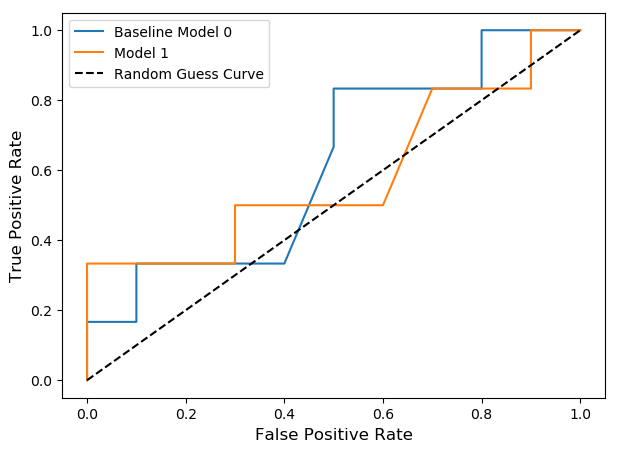

In [61]:
plt.figure(figsize=(7,5))

plt.plot(fprs, tprs, label="Baseline Model 0")
plt.plot(fprs_1, tprs_1, label="Model 1")
plt.plot([0,1], [0,1], 'k--', label="Random Guess Curve")


plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)

plt.show()

# Using more inputs: Model 2

In [64]:
# Instantiate the logistic regression
log_reg = LogisticRegression(penalty=None)

# Fit the model
log_reg.fit(X_train[['total_carb','gi','sugar','protein','total_fat']].values,
            y_train)

LogisticRegression(penalty=None)

In [65]:
# Set the cutoff
cutoff = .4

# Store the predicted probabilities
y_prob = log_reg.predict_proba(X_train[['total_carb','gi','sugar','protein','total_fat']].values)[:,1]

# Assign the value based on the cutoff
y_train_pred = 1*(y_prob >= cutoff)

# Print the accuracy
print("The training accuracy for a cutoff of",cutoff,
      "is", np.sum(y_train_pred == y_train)/len(y_train))

The training accuracy for a cutoff of 0.4 is 0.5625


In [66]:
## Now plot how the accuracy changes with the cutoff
cutoffs = np.arange(0,1.01,.01)
accs = []

for cutoff in cutoffs:
    y_train_pred = 1*(y_prob >= cutoff)
    accs.append(np.sum(y_train_pred == y_train)/len(y_train))

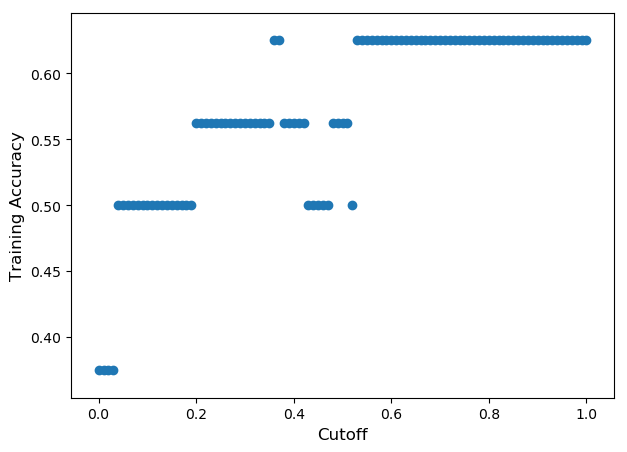

In [67]:
plt.figure(figsize=(7,5))

plt.scatter(cutoffs,accs)

plt.xlabel("Cutoff",fontsize=12)
plt.ylabel("Training Accuracy",fontsize=12)

plt.show()

In [68]:
# Set the cutoff
cutoff = .35

# Store the predicted probabilities
y_prob = log_reg.predict_proba(X_train[['total_carb','gi','sugar','protein','total_fat']].values)[:,1]

# Assign the value based on the cutoff
y_train_pred = 1*(y_prob >= cutoff)

# Confustion matrix
confusion_matrix(y_train, y_train_pred)

array([[3, 7],
       [0, 6]], dtype=int64)

In [69]:
TN = confusion_matrix(y_train, y_train_pred)[0,0]
FP = confusion_matrix(y_train, y_train_pred)[0,1]
FN = confusion_matrix(y_train, y_train_pred)[1,0]
TP = confusion_matrix(y_train, y_train_pred)[1,1]

## TPR
print("The training true positive rate is",
         np.round(TP/(TP+FN),4))

## FNR
print("The training false negative rate is",
         np.round(FN/(TP+FN),4))

## TNR
print("The training true negative rate is",
         np.round(TN/(TN+FP),4))

## FPR
print("The training false positive rate is",
         np.round(FP/(FP+TN),4))

The training true positive rate is 1.0
The training false negative rate is 0.0
The training true negative rate is 0.3
The training false positive rate is 0.7


In [70]:
fprs_2, tprs_2, cutoffs_2 = roc_curve(y_train, y_prob)

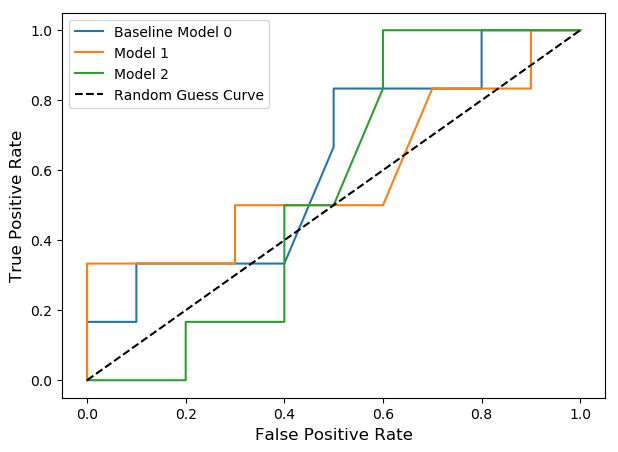

In [71]:
plt.figure(figsize=(7,5))

plt.plot(fprs, tprs, label="Baseline Model 0")
plt.plot(fprs_1, tprs_1, label="Model 1")
plt.plot(fprs_2, tprs_2, label="Model 2")
plt.plot([0,1], [0,1], 'k--', label="Random Guess Curve")


plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)

plt.show()

# Using more inputs: Model 3

In [73]:
# Instantiate the logistic regression
log_reg = LogisticRegression(penalty=None)

# Fit the model
log_reg.fit(X_train[['total_carb','gi','start_glucose']].values,
            y_train)

LogisticRegression(penalty=None)

In [74]:
# Set the cutoff
cutoff = .4

# Store the predicted probabilities
y_prob = log_reg.predict_proba(X_train[['total_carb','gi','start_glucose']].values)[:,1]

# Assign the value based on the cutoff
y_train_pred = 1*(y_prob >= cutoff)

# Print the accuracy
print("The training accuracy for a cutoff of",cutoff,
      "is", np.sum(y_train_pred == y_train)/len(y_train))

The training accuracy for a cutoff of 0.4 is 0.625


In [75]:
## Now plot how the accuracy changes with the cutoff
cutoffs = np.arange(0,1.01,.01)
accs = []

for cutoff in cutoffs:
    y_train_pred = 1*(y_prob >= cutoff)
    accs.append(np.sum(y_train_pred == y_train)/len(y_train))

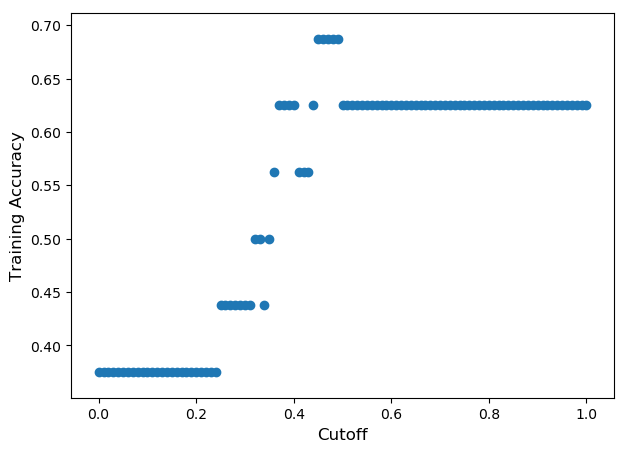

In [76]:
plt.figure(figsize=(7,5))

plt.scatter(cutoffs,accs)

plt.xlabel("Cutoff",fontsize=12)
plt.ylabel("Training Accuracy",fontsize=12)

plt.show()

In [77]:
# Set the cutoff
cutoff = .35

# Store the predicted probabilities
y_prob = log_reg.predict_proba(X_train[['total_carb','gi','start_glucose']].values)[:,1]

# Assign the value based on the cutoff
y_train_pred = 1*(y_prob >= cutoff)

# Confustion matrix
confusion_matrix(y_train, y_train_pred)

array([[5, 5],
       [3, 3]], dtype=int64)

In [78]:
TN = confusion_matrix(y_train, y_train_pred)[0,0]
FP = confusion_matrix(y_train, y_train_pred)[0,1]
FN = confusion_matrix(y_train, y_train_pred)[1,0]
TP = confusion_matrix(y_train, y_train_pred)[1,1]

## TPR
print("The training true positive rate is",
         np.round(TP/(TP+FN),4))

## FNR
print("The training false negative rate is",
         np.round(FN/(TP+FN),4))

## TNR
print("The training true negative rate is",
         np.round(TN/(TN+FP),4))

## FPR
print("The training false positive rate is",
         np.round(FP/(FP+TN),4))

The training true positive rate is 0.5
The training false negative rate is 0.5
The training true negative rate is 0.5
The training false positive rate is 0.5


In [79]:
fprs_3, tprs_3, cutoffs_3 = roc_curve(y_train, y_prob)

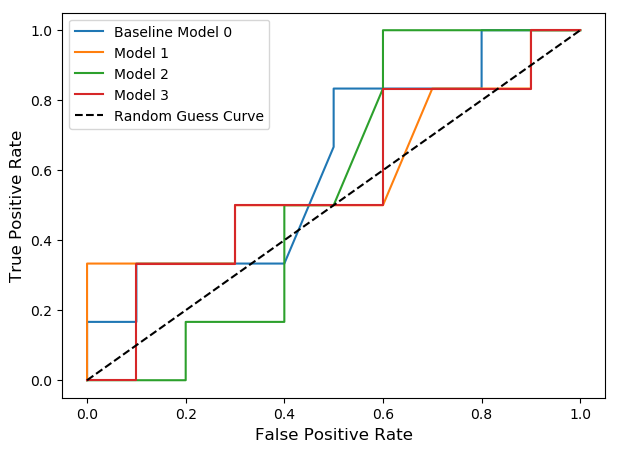

In [80]:
plt.figure(figsize=(7,5))

plt.plot(fprs, tprs, label="Baseline Model 0")
plt.plot(fprs_1, tprs_1, label="Model 1")
plt.plot(fprs_2, tprs_2, label="Model 2")
plt.plot(fprs_3, tprs_3, label="Model 3")
plt.plot([0,1], [0,1], 'k--', label="Random Guess Curve")


plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)

plt.show()

# Using more inputs: Model 4

In [82]:
# Instantiate the logistic regression
log_reg = LogisticRegression(penalty=None)

# Fit the model
log_reg.fit(X_train[['total_carb','gi','start_glucose','sugar','protein','total_fat']].values,
            y_train)

LogisticRegression(penalty=None)

In [83]:
# Set the cutoff
cutoff = .4

# Store the predicted probabilities
y_prob = log_reg.predict_proba(X_train[['total_carb','gi','start_glucose','sugar','protein','total_fat']].values)[:,1]

# Assign the value based on the cutoff
y_train_pred = 1*(y_prob >= cutoff)

# Print the accuracy
print("The training accuracy for a cutoff of",cutoff,
      "is", np.sum(y_train_pred == y_train)/len(y_train))

The training accuracy for a cutoff of 0.4 is 0.5625


In [84]:
## Now plot how the accuracy changes with the cutoff
cutoffs = np.arange(0,1.01,.01)
accs = []

for cutoff in cutoffs:
    y_train_pred = 1*(y_prob >= cutoff)
    accs.append(np.sum(y_train_pred == y_train)/len(y_train))

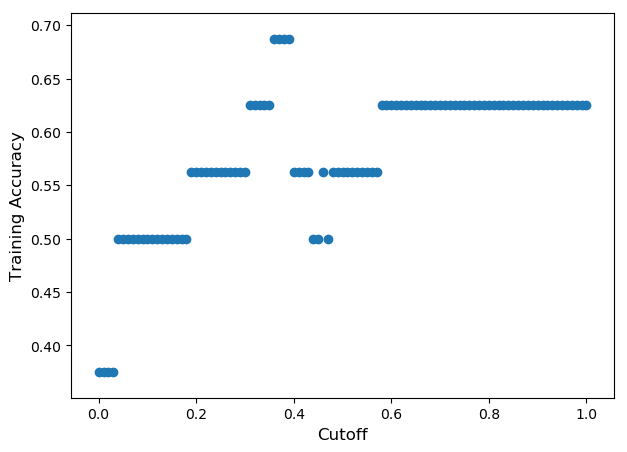

In [85]:
plt.figure(figsize=(7,5))

plt.scatter(cutoffs,accs)

plt.xlabel("Cutoff",fontsize=12)
plt.ylabel("Training Accuracy",fontsize=12)

plt.show()

In [86]:
# Set the cutoff
cutoff = .35

# Store the predicted probabilities
y_prob = log_reg.predict_proba(X_train[['total_carb','gi','start_glucose','sugar','protein','total_fat']].values)[:,1]

# Assign the value based on the cutoff
y_train_pred = 1*(y_prob >= cutoff)

# Confustion matrix
confusion_matrix(y_train, y_train_pred)

array([[4, 6],
       [0, 6]], dtype=int64)

In [87]:
TN = confusion_matrix(y_train, y_train_pred)[0,0]
FP = confusion_matrix(y_train, y_train_pred)[0,1]
FN = confusion_matrix(y_train, y_train_pred)[1,0]
TP = confusion_matrix(y_train, y_train_pred)[1,1]

## TPR
print("The training true positive rate is",
         np.round(TP/(TP+FN),4))

## FNR
print("The training false negative rate is",
         np.round(FN/(TP+FN),4))

## TNR
print("The training true negative rate is",
         np.round(TN/(TN+FP),4))

## FPR
print("The training false positive rate is",
         np.round(FP/(FP+TN),4))

The training true positive rate is 1.0
The training false negative rate is 0.0
The training true negative rate is 0.4
The training false positive rate is 0.6


In [88]:
fprs_4, tprs_4, cutoffs_4 = roc_curve(y_train, y_prob)

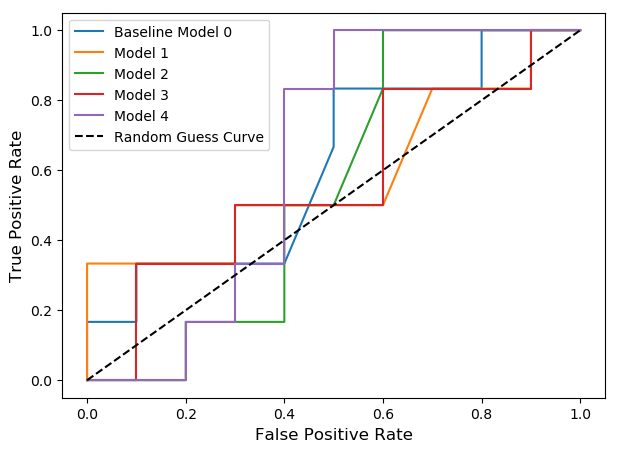

In [89]:
plt.figure(figsize=(7,5))

plt.plot(fprs, tprs, label="Baseline Model 0")
plt.plot(fprs_1, tprs_1, label="Model 1")
plt.plot(fprs_2, tprs_2, label="Model 2")
plt.plot(fprs_3, tprs_3, label="Model 3")
plt.plot(fprs_4, tprs_4, label="Model 4")
plt.plot([0,1], [0,1], 'k--', label="Random Guess Curve")


plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)

plt.show()